In [1]:
import numpy as np

import pandas as pd

import scipy
import scipy.sparse as sp

import tensorflow as tf

class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


In [2]:

df = pd.read_csv("polyadb_processed_v3_utr3_isoforms.csv", sep='\t')


In [3]:

df


,gene_id,seq
0,A1BG.1,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...
1,A1BG.2,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...
2,A1BG.3,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...
3,A1BG.4,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...
4,A1BG.5,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...
...,...,...
84718,ZZZ3.5,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...
84719,ZZZ3.6,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...
84720,ZZZ3.7,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...
84721,ZZZ3.8,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...


In [4]:
#From Sabeti_testSet/pmirGLO_construct.txt

utr5 = "GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCGGCCAATAGCAGCTTTGCTCCTTCGCTTTCTGGGCTCAGAGGCTGGGAAGGGGTGGGTCCGGGGGCGGGCTCAGGGGCGGGCTCAGGGGCGGGGCGGGCGCCCGAAGGTCCTCCGGAGGCCCGGCATTCTGCACGCTTCAAAAGCGCACGTCTGCCGCGCTGTTCTCCTCTTCCTCATCTCCGGGCCTTTCGACCTGCAGCCCAAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACC"
orf = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCTTCACCTACGGCGTGCAGTGCTTCGCCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAAGGTCTATATCACCGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGACCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA"

print("len(utr5) = " + str(len(utr5)))
print("len(orf) = " + str(len(orf)))

df['full_seq'] = utr5 + orf + df['seq'].str.slice(3)


len(utr5) = 283
len(orf) = 720


In [5]:
df

,gene_id,seq,full_seq
0,A1BG.1,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
1,A1BG.2,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
2,A1BG.3,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
3,A1BG.4,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
4,A1BG.5,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
...,...,...,...
84718,ZZZ3.5,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
84719,ZZZ3.6,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
84720,ZZZ3.7,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
84721,ZZZ3.8,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...


In [15]:

#!wget https://zenodo.org/record/6326409/files/datasets.zip?download=1


--2022-04-02 22:38:48--  https://zenodo.org/record/6326409/files/datasets.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18751132386 (17G) [application/octet-stream]
Saving to: ‘datasets.zip?download=1’

datasets.zip?downlo 100%[===================>]  17.46G  7.88MB/s    in 30m 35s 

2022-04-02 23:09:25 (9.74 MB/s) - ‘datasets.zip?download=1’ saved [18751132386/18751132386]



In [19]:

#!unzip ./datasets.zip "datasets/deeplearning/train_gru/params.json" -d "./"
#!unzip ./datasets.zip "datasets/deeplearning/train_gru/f8_c4/train/model0_best.h5" -d "./"


Archive:  ./datasets.zip
  inflating: ./datasets/deeplearning/train_gru/f8_c4/train/model0_best.h5  


In [6]:
import os, sys
import argparse, json, h5py, time

from basenji import dna_io

try:
    import rnann
except:
    from basenji import rnann

encode_batch_size = 4800
predict_batch_size = 64
MAXLEN = 12288

params_file = "datasets/deeplearning/train_gru/params.json"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_model = params['model']
params_train = params['train']

aa_len = int(len(orf)/3)
coding = np.append(np.zeros(len(utr5)), np.tile([1,0,0], aa_len))

seqs = df['full_seq'].values.tolist()

batch_remainder = (encode_batch_size - len(seqs) % encode_batch_size) if len(seqs) % encode_batch_size > 0 else 0

seqs.extend([df.iloc[-1]['full_seq'] for i in range(batch_remainder)])

n_batches = len(seqs) // encode_batch_size

print("n_batches = " + str(n_batches))

#One-hot encode and predict mini-batches

for f in range(10) :
    for c in range(5) :

        print('f' + str(f) + '_c' + str(c))
        
        model_file = "datasets/deeplearning/train_gru/f" + str(f) + "_c" + str(c) + "/train/model0_best.h5"

        # initialize model
        seqnn_model = rnann.RnaNN(params_model)
        seqnn_model.restore(model_file)
        
        preds = []
        for batch_ix in range(n_batches) :

            if batch_ix % 1 == 0 : 
                print("batch_ix = " + str(batch_ix))

            batch = np.zeros((encode_batch_size,MAXLEN,6))

            for i, myseq in enumerate(seqs[batch_ix*encode_batch_size:(batch_ix+1)*encode_batch_size]) :
                batch[i,0:len(myseq),0:4] = dna_io.dna_1hot(myseq)
                batch[i,0:len(coding),4] = coding

            pred = seqnn_model.predict(batch, batch_size=predict_batch_size)

            preds.append(pred)

        preds = np.concatenate(preds, axis=0)[:len(df), 0]

        df['isoform_hl_f' + str(f) + '_c' + str(c)] = preds


n_batches = 18
f0_c0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift (Stochastic (None, 12288, 6)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization (LayerNo (None, 12284, 64)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 12284, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12280, 64)         20544     
_________________________________________________________________
dropout (Dropout)            (None, 1228

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f0_c2
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_2 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_14 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 12284, 64)         0         
______________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f0_c4
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_4 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_28 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 12284, 64)         0         
______________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f1_c1
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_6 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_42 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f1_c3
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_8 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_56 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_72 (ReLU)              (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f2_c0
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_10 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_70 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_90 (ReLU)              (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f2_c2
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_12 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_84 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_108 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f2_c4
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_14 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_98 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_126 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f3_c1
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_16 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_112 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_144 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f3_c3
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_18 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_126 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_162 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f4_c0
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_20 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_140 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_180 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f4_c2
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_22 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_154 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_198 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f4_c4
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_24 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_168 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_216 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f5_c1
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_26 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_182 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_234 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f5_c3
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_28 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_196 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_252 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f6_c0
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_30 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_210 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_270 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f6_c2
Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_32 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_224 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_224 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_288 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f6_c4
Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_34 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_238 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_238 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_306 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 12280, 64)         20544     
_________________________________________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f7_c1
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_36 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_252 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_252 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_324 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f7_c3
Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_38 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_266 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_266 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_342 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f8_c0
Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_40 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_280 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_360 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f8_c2
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_42 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_294 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_294 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_378 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f8_c4
Model: "model_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_44 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_308 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_308 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_396 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f9_c1
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_46 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_322 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_322 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_414 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17
f9_c3
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_48 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_336 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_336 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_432 (ReLU)             (None, 12284, 64)         0         
_____________________

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
batch_ix = 10
batch_ix = 11
batch_ix = 12
batch_ix = 13
batch_ix = 14
batch_ix = 15
batch_ix = 16
batch_ix = 17


In [7]:
df

,gene_id,seq,full_seq,isoform_hl_f0_c0,isoform_hl_f0_c1,isoform_hl_f0_c2,isoform_hl_f0_c3,isoform_hl_f0_c4,isoform_hl_f1_c0,isoform_hl_f1_c1,...,isoform_hl_f8_c0,isoform_hl_f8_c1,isoform_hl_f8_c2,isoform_hl_f8_c3,isoform_hl_f8_c4,isoform_hl_f9_c0,isoform_hl_f9_c1,isoform_hl_f9_c2,isoform_hl_f9_c3,isoform_hl_f9_c4
0,A1BG.1,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.388017,-1.144652,-0.646688,-0.674588,-0.890532,-0.703598,-0.361942,...,-0.902631,-1.127487,-0.212410,-0.262012,-0.697976,-0.852198,-0.845392,-1.134645,-1.547194,-0.871649
1,A1BG.2,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.344862,-1.166471,-0.752094,-0.713986,-0.889778,-0.718926,-0.463274,...,-0.897309,-1.174992,-0.253272,-0.298092,-0.792574,-0.905793,-0.992613,-1.138781,-1.631888,-0.897528
2,A1BG.3,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.290631,-1.185247,-0.820668,-0.769758,-0.912439,-0.775609,-0.491822,...,-0.962786,-1.205053,-0.293289,-0.315679,-0.868886,-0.935165,-1.072572,-1.141392,-1.679117,-0.950575
3,A1BG.4,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.442486,-1.144861,-0.572076,-0.643555,-0.804778,-0.675348,-0.300037,...,-0.742558,-1.189579,-0.145412,-0.186263,-0.580326,-0.825359,-0.899775,-1.071075,-1.600610,-0.829922
4,A1BG.5,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.102148,-1.233107,-0.873112,-0.741365,-0.908657,-0.716030,-0.330139,...,-0.863227,-1.350082,-0.248833,-0.331310,-0.664863,-1.070275,-1.113604,-1.091675,-1.796230,-1.122240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84718,ZZZ3.5,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.401398,-1.273319,-1.265862,-0.074252,-0.935389,-0.840047,-0.574682,...,-0.847683,-1.493777,-0.069766,-0.252332,-0.836874,-1.224963,-0.878579,-0.802866,-1.740808,-0.960368
84719,ZZZ3.6,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.283521,-1.359920,-1.369461,-0.200248,-1.080053,-1.052075,-0.749988,...,-1.021260,-1.612098,-0.092128,-0.269091,-0.902714,-1.390216,-1.076280,-0.880068,-1.869193,-1.100774
84720,ZZZ3.7,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.125851,-1.450723,-1.581395,-0.281844,-1.150441,-1.179661,-0.809309,...,-1.069103,-1.643629,-0.179602,-0.457549,-0.999991,-1.432856,-1.203226,-0.968592,-1.952316,-1.233923
84721,ZZZ3.8,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.152619,-1.378147,-1.264758,-0.190004,-1.188191,-1.077006,-0.853885,...,-1.035464,-1.657070,-0.208362,-0.372307,-0.900882,-1.510506,-1.249800,-0.783099,-1.960925,-1.127539


In [8]:

df.drop(columns=['seq', 'full_seq']).to_csv("polyadb_processed_v3_utr3_isoforms_saluki_pred.csv", sep='\t')
df = pd.read_csv("polyadb_processed_v3_utr3_isoforms_saluki_pred.csv", sep='\t')


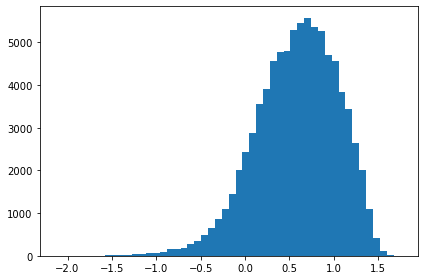

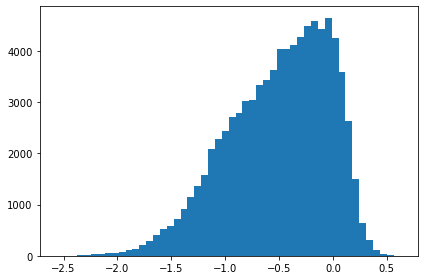

In [10]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6, 4))

plt.hist(df['isoform_hl_f0_c0'].values, bins=50)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(6, 4))

plt.hist(df['isoform_hl_f0_c4'].values, bins=50)

plt.tight_layout()

plt.show()
